# Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
from time import perf_counter
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import category_encoders as ce
from sklearn.ensemble import VotingClassifier
%matplotlib inline 

## Reading the data

In [2]:
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data",
                names = ["Male","Age","Debt","Married","BankCustomer","EducationLevel",
                         "Ethnicity","YearsEmployed","PriorDefault","Employed","CreditScore",
                         "DriversLicense","Citizen","ZipCode","Income","Approved"]
                ,na_values=['?'])

In [3]:
df.head()

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


## Data information

In [9]:
#Knowing how many non unique value in each feature
for column in list(df.columns.values):
    print(f"Number of non unique values in column {column} = {df[column].nunique()}")  

Number of non unique values in column Male = 2
Number of non unique values in column Age = 349
Number of non unique values in column Debt = 215
Number of non unique values in column Married = 3
Number of non unique values in column BankCustomer = 3
Number of non unique values in column EducationLevel = 14
Number of non unique values in column Ethnicity = 9
Number of non unique values in column YearsEmployed = 132
Number of non unique values in column PriorDefault = 2
Number of non unique values in column Employed = 2
Number of non unique values in column CreditScore = 23
Number of non unique values in column DriversLicense = 2
Number of non unique values in column Citizen = 3
Number of non unique values in column ZipCode = 170
Number of non unique values in column Income = 240
Number of non unique values in column Approved = 2


## Removing unneeded columns

In [5]:
df = df.loc[:, df.columns != 'ZipCode']

## Working on the dependent variable

In [4]:
df["Approved"].replace("+", 1,inplace = True)
df["Approved"].replace("-", 0,inplace = True)
print(df["Approved"].value_counts())

0    383
1    307
Name: Approved, dtype: int64


In [12]:
df.describe()

,Age,Debt,YearsEmployed,CreditScore,Income,Approved
count,678.000000,690.000000,690.000000,690.00000,690.000000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,1017.385507,0.444928
std,11.957862,4.978163,3.346513,4.86294,5210.102598,0.497318
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,0.000000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,5.000000,0.000000
75%,38.230000,7.207500,2.625000,3.00000,395.500000,1.000000
max,80.250000,28.000000,28.500000,67.00000,100000.000000,1.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            678 non-null    object 
 1   Age             678 non-null    float64
 2   Debt            690 non-null    float64
 3   Married         684 non-null    object 
 4   BankCustomer    684 non-null    object 
 5   EducationLevel  681 non-null    object 
 6   Ethnicity       681 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  Income          690 non-null    int64  
 14  Approved        690 non-null    int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 81.0+ KB


## infromation about data

In [14]:
for col in df.select_dtypes(include=np.number).columns:
    print(f"Variance of {col} is {df[col].var()}")

Variance of Age is 142.99047552755303
Variance of Debt is 24.782109329000235
Variance of YearsEmployed is 11.199151663827012
Variance of CreditScore is 23.64818577648766
Variance of Income is 27145169.084840447
Variance of Approved is 0.2473254664394943


In [15]:
for col in df.select_dtypes(include=np.number).columns:
    print(f"Skewness of {col} is {df[col].skew()}")

Skewness of Age is 1.1458915555559264
Skewness of Debt is 1.4888131246649208
Skewness of YearsEmployed is 2.891330424153805
Skewness of CreditScore is 5.152519857445985
Skewness of Income is 13.140655014445459
Skewness of Approved is 0.22212157058948015


## Checking for outliers

In [6]:
#Filtering the outliers using Zscore method
def filter_zscore(df, column_name):
    print(f"====== {column_name} ======")
    print(f"Mean of values is: {df[column_name].mean()}")
    print(f"Stanndard Deviation of values is: {df[column_name].std()}\n")
    print(f"length of data before filtering is {len(df)}")        
    filtered = df[(np.abs(zscore(df[column_name], nan_policy='omit')) < 3)]
    print(f"length of data after filtering is {len(filtered)}")
    return filtered.index.tolist()

index_set = set(df.index.tolist())
for col in df.select_dtypes(include=np.number).columns:
    index_set = set(filter_zscore(df, col)).intersection(index_set)

df = df.loc[set(index_set)]
df

====== Age ======
Mean of values is: 31.56817109144543
Stanndard Deviation of values is: 11.957862498270877

length of data before filtering is 690
length of data after filtering is 669
====== Debt ======
Mean of values is: 4.758724637681159
Stanndard Deviation of values is: 4.978163248528541

length of data before filtering is 690
length of data after filtering is 680
====== YearsEmployed ======
Mean of values is: 2.223405797101449
Stanndard Deviation of values is: 3.3465133592781324

length of data before filtering is 690
length of data after filtering is 668
====== CreditScore ======
Mean of values is: 2.4
Stanndard Deviation of values is: 4.862940034226996

length of data before filtering is 690
length of data after filtering is 682
====== Income ======
Mean of values is: 1017.3855072463768
Stanndard Deviation of values is: 5210.10259830269

length of data before filtering is 690
length of data after filtering is 684
====== Approved ======
Mean of values is: 0.4449275362318841
Stan

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,0,0
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,394,0
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,1,0
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,750,0


## Some plots

<AxesSubplot:>

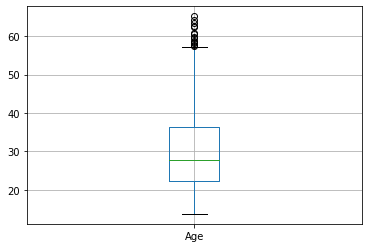

In [17]:
df.boxplot(column='Age')

<AxesSubplot:>

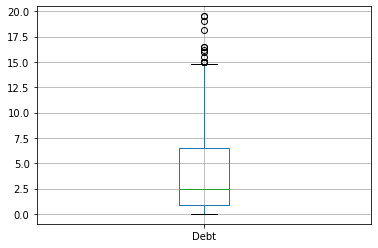

In [18]:
df.boxplot(column='Debt')

<AxesSubplot:>

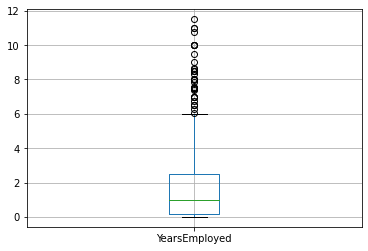

In [19]:
df.boxplot(column='YearsEmployed')

Text(0.5, 0.98, 'Approved (1 = Accepted, 0 = Rejected)')

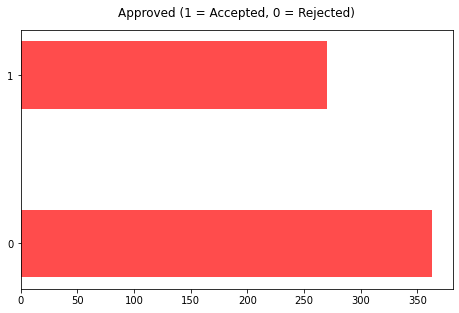

In [20]:
counts_Approved = df["Approved"].value_counts()
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, .9]) 

ax.barh(list(counts_Approved.index), list(counts_Approved), color='r',
        alpha=0.7, height=0.4)

ax.set_yticks(list(counts_Approved.index))
fig.suptitle("Approved (1 = Accepted, 0 = Rejected)")


## Handling missing values 

In [7]:
#Replacing the nan values with mean value in case of numerical
imputer = SimpleImputer(strategy="mean")
df.loc[:, df.select_dtypes(include=np.number).columns] = imputer.fit_transform(df.loc[:, df.select_dtypes(include=np.number).columns]) 
df.isna().sum() 

#Replacing the nan values with mode value in case of categorical

for column in df.select_dtypes(include=object).columns:
    df[column] = df[column].fillna(value=df[column].mode()[0])

In [ ]:
print(df.isna().sum(), "\n\n")

## Categorical encoding

In [8]:
#Applying label encoding
enc = ce.OrdinalEncoder(cols=df.select_dtypes(include=object).columns.tolist())
df = enc.fit_transform(df)
df

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
0,1,30.83,0.000,1,1,1,1,1.25,1,1,1.0,1,1,0.0,1.0
1,2,58.67,4.460,1,1,2,2,3.04,1,1,6.0,1,1,560.0,1.0
2,2,24.50,0.500,1,1,2,2,1.50,1,2,0.0,1,1,824.0,1.0
3,1,27.83,1.540,1,1,1,1,3.75,1,1,5.0,2,1,3.0,1.0
4,1,20.17,5.625,1,1,1,1,1.71,1,2,0.0,1,2,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,21.08,10.085,2,2,10,2,1.25,2,2,0.0,1,1,0.0,0.0
686,2,22.67,0.750,1,1,6,1,2.00,2,1,2.0,2,1,394.0,0.0
687,2,25.25,13.500,2,2,12,4,2.00,2,1,1.0,2,1,1.0,0.0
688,1,17.92,0.205,1,1,11,1,0.04,2,2,0.0,1,1,750.0,0.0


In [ ]:
#Checking for nan values
print(df.isna().sum(), "\n\n")
print(df['Male'].value_counts())

## Feature Scaling

In [9]:
#Applying min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.loc[:, df.select_dtypes(include=np.number).columns] = scaler.fit_transform(df.loc[:, df.select_dtypes(include=np.number).columns]) 


In [10]:
print(df.isna().sum(), "\n\n")
print(df['Male'].value_counts())

Male              0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
Income            0
Approved          0
dtype: int64 


0.0    437
1.0    196
Name: Male, dtype: int64


## Determining the dependent variable

In [11]:
labels = df.pop("Approved")

## Applying k-fold

In [12]:
k = 5
kf = KFold(n_splits=k, random_state=None)
X_Train , X_Test ,Y_Train , Y_Test = train_test_split(df,labels,test_size=.25,random_state=1)

# Trying classification models

## Logistic Regression

In [13]:
Logistic = LogisticRegression()
#Applying cross validation across the training data
total_acc = []
for train_index , val_index in kf.split(X_Train):
    X_train , X_val = X_Train.iloc[train_index,:],X_Train.iloc[val_index,:]
    Y_train , Y_val = Y_Train.iloc[train_index] , Y_Train.iloc[val_index]
    Logistic.fit(X_train, Y_train)
    Y_pred = Logistic.predict(X_val)
    acc = accuracy_score(Y_pred , Y_val)
    total_acc.append(acc)    
avg_acc = sum(total_acc)/5

print(avg_acc)
print(Logistic.score(X_Test , Y_Test))

0.8585890257558791
0.8867924528301887


## KNN

In [14]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_Train, Y_Train)
print(knn.score(X_Test , Y_Test))

0.8679245283018868


## Support vector classifier

In [15]:
model = SVC(kernel='rbf', degree=3, C=1E6)
model.fit(X_Train, Y_Train)
print(model.score(X_Test , Y_Test))

0.7484276729559748


## Decision trees

In [16]:
hp = {
    'max_depth': 5,
    'min_samples_split': 10
}
DTC = DecisionTreeClassifier(**hp)
DTC.fit(X_Train,Y_Train)
print(DTC.score(X_Test , Y_Test))

0.8553459119496856


## Random forests

In [17]:
RFC = RandomForestClassifier(random_state=0)
total_acc = []
for train_index , val_index in kf.split(X_Train):
    X_train , X_val = X_Train.iloc[train_index,:],X_Train.iloc[val_index,:]
    Y_train , Y_val = Y_Train.iloc[train_index] , Y_Train.iloc[val_index]
    RFC.fit(X_train, Y_train)
    Y_pred = RFC.predict(X_val)
    acc = accuracy_score(Y_pred , Y_val)
    total_acc.append(acc)    
avg_acc = sum(total_acc)/5
RFC.fit(X_Train,Y_Train)
print(avg_acc)
print(RFC.score(X_Test , Y_Test))

0.8502351623740202
0.8742138364779874


## Knowing feature importances

<AxesSubplot:>

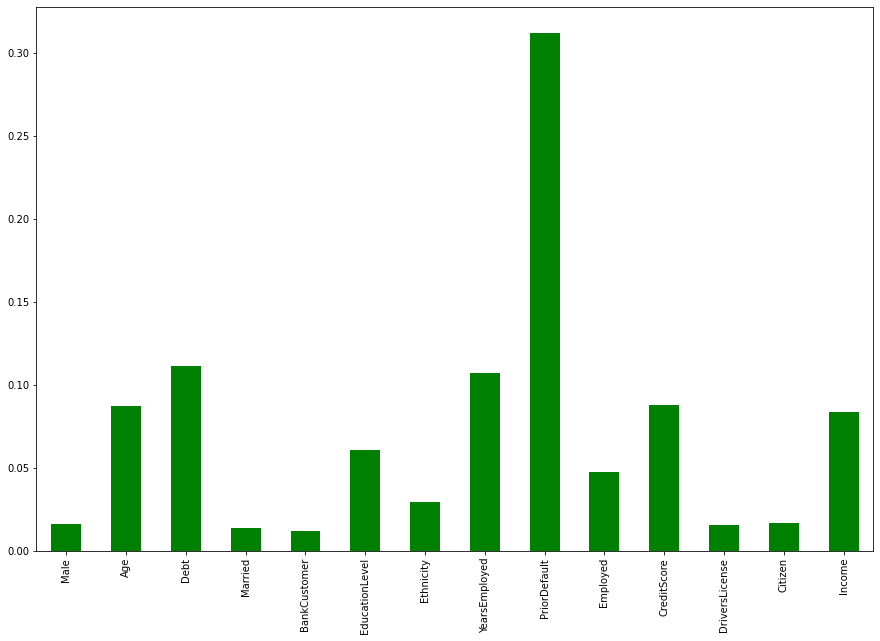

In [31]:
plt.figure(figsize=(15,10))
pd.Series(RFC.feature_importances_ , index = X_Train.columns).plot(kind="bar",color=['green'])

## Removing useless columns

In [16]:
df = df.drop(['Male','Citizen','Married','BankCustomer','DriversLicense'],axis=1)

In [32]:
X_Train , X_Test ,Y_Train , Y_Test = train_test_split(df,labels,test_size=.25,random_state=1)


## Grid searching to get the best params for random forests

In [ ]:
params = dict()
params['n_estimators'] = list(range(1,15))
params['max_features'] = [0.6 , 0.7 , 0.8 , 0.9]
params['max_depth'] = list(range(1,10))
params['min_samples_split'] = list(range(10,30))
start = perf_counter()

gs = GridSearchCV(RandomForestClassifier(),param_grid = params , n_jobs = -1)
gs.fit(X_Train,Y_Train)
end = perf_counter()
print("Time = " , end-start)
print("Best score = ", gs.best_score_)
print("Best Hyperparameters = " , gs.best_params_)

In [21]:
RFC2 = RandomForestClassifier(n_estimators=8, max_features=0.7, max_depth=9, min_samples_split=14)

total_acc = []
for train_index , val_index in kf.split(X_Train):
    X_train , X_val = X_Train.iloc[train_index,:],X_Train.iloc[val_index,:]
    Y_train , Y_val = Y_Train.iloc[train_index] , Y_Train.iloc[val_index]
    RFC2.fit(X_train, Y_train)
    Y_pred = RFC2.predict(X_val)
    acc = accuracy_score(Y_pred , Y_val)
    total_acc.append(acc)    
avg_acc = sum(total_acc)/5
print(avg_acc)
print(RFC2.score(X_Test , Y_Test))

0.850212765957447
0.8930817610062893


In [22]:
Logistic2 = LogisticRegression()

total_acc = []
for train_index , val_index in kf.split(X_Train):
    X_train , X_val = X_Train.iloc[train_index,:],X_Train.iloc[val_index,:]
    Y_train , Y_val = Y_Train.iloc[train_index] , Y_Train.iloc[val_index]
    Logistic2.fit(X_train, Y_train)
    Y_pred = Logistic2.predict(X_val)
    acc = accuracy_score(Y_pred , Y_val)
    total_acc.append(acc)    
avg_acc = sum(total_acc)/5

print(avg_acc)
print(Logistic2.score(X_Test , Y_Test))

0.8585890257558791
0.8867924528301887


## Grid searching to get the best params for KNN

In [ ]:
params = dict()
params['n_neighbors'] = list(range(1,15))
params['metric'] = ['euclidean','manhattan','minkowski']
params['weights'] = ['unifrom','distance']

start = perf_counter()

gs = GridSearchCV(KNeighborsClassifier(),param_grid = params , n_jobs = -1)
gs.fit(X_Train,Y_Train)
end = perf_counter()
print("Time = " , end-start)
print("Best score = ", gs.best_score_)
print("Best Hyperparameters = " , gs.best_params_)

In [35]:
knn2 = KNeighborsClassifier(n_neighbors=13,metric='manhattan',weights='distance')

total_acc = []
for train_index , val_index in kf.split(X_Train):
    X_train , X_val = X_Train.iloc[train_index,:],X_Train.iloc[val_index,:]
    Y_train , Y_val = Y_Train.iloc[train_index] , Y_Train.iloc[val_index]
    knn2.fit(X_train, Y_train)
    Y_pred = knn2.predict(X_val)
    acc = accuracy_score(Y_pred , Y_val)
    total_acc.append(acc)   
    
avg_acc = sum(total_acc)/5
print(avg_acc)
print(knn2.score(X_Test , Y_Test))

0.8437849944008958
0.8805031446540881


## Applying ensembling voting classifier between the best models

In [37]:
eclf = VotingClassifier(estimators=[('rf', RFC2), ('log', Logistic2),
                                    ('knn', knn2)],
                        voting='soft', weights=[1, 1, 1])
eclf.fit(X_Train, Y_Train)
print(eclf.score(X_Test , Y_Test))

0.9056603773584906
